In [1]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

In [2]:
# Setup
if torch.cuda.device_count():
    device = torch.device("cuda:1")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "dog_mesh/13466_Canaan_Dog_v1_L3.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

In [7]:
type(mesh)

pytorch3d.structures.meshes.Meshes

In [3]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction.
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow.
R, T = look_at_view_transform(80, 30, 180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of
# the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the
# -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -70.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will
# interpolate the texture uv coordinates for each vertex, sample from a texture image and
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

In [4]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures.
# Meshes has a useful `extend` method which allows us do this very easily.
# This also extends the textures.
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles.
elev = torch.linspace(30, 40, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors.
R, T = look_at_view_transform(dist=80, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
cameras.image_size = (512, 512)

# Move the light back in front of the cow which is facing the -z direction.
lights.location = torch.tensor([[0.0, 0.0, -70.0]], device=device)

In [5]:
# We can pass arbitrary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)

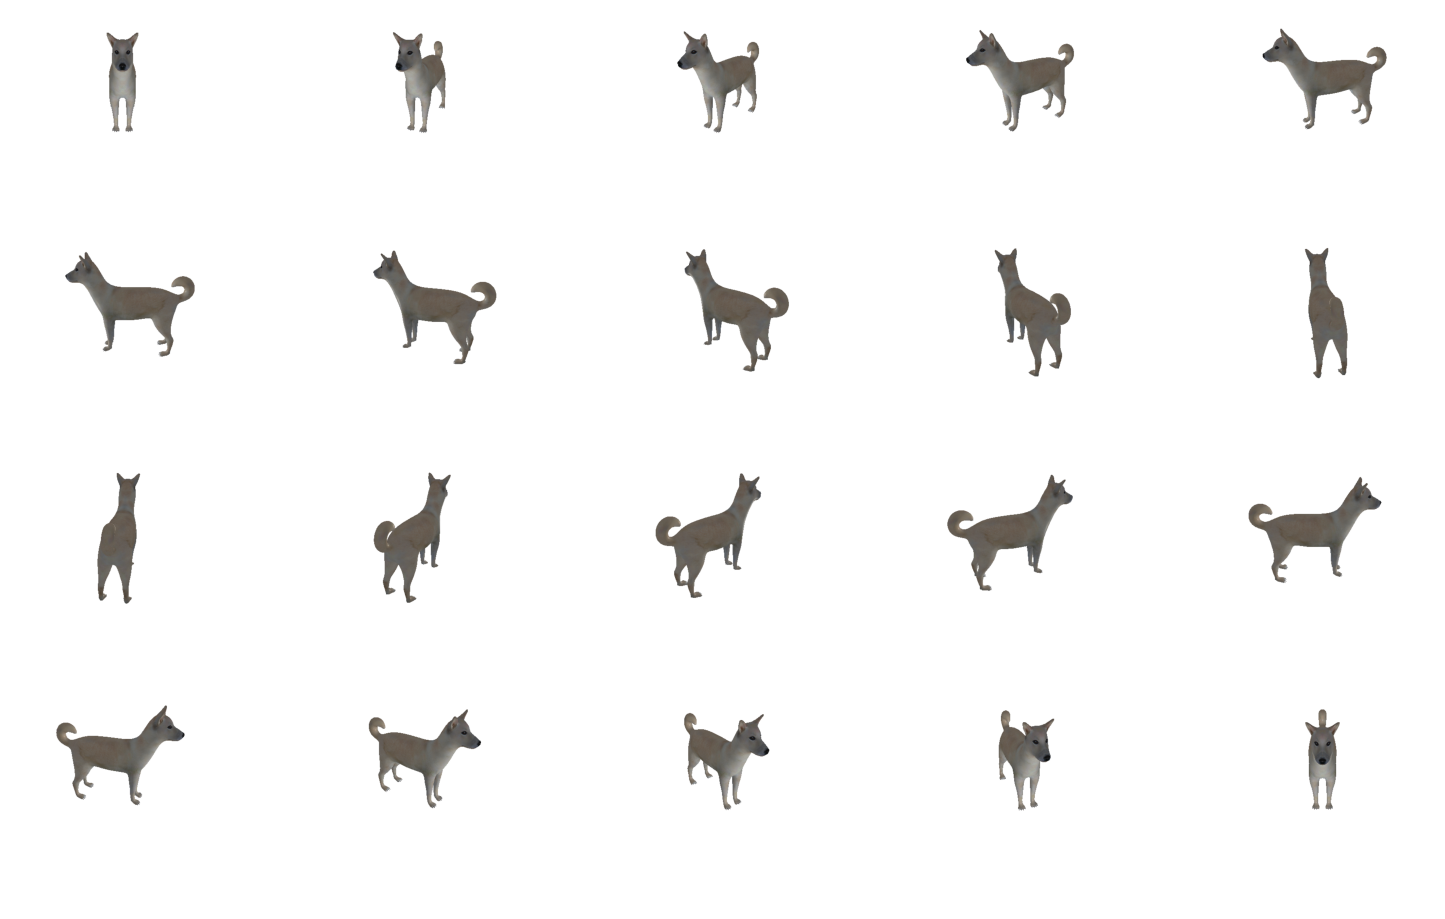

In [6]:
from plot_image_grid import image_grid

image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True, folder=os.path.join(DATA_DIR, 'dog_mesh_views'))

In [1]:
import torch
import numpy as np
from torchvision.ops import box_convert
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from grounding_dino.groundingdino.util.inference import load_model, load_image, predict


SAM2_CHECKPOINT = "./checkpoints/sam2.1_hiera_large.pt"
SAM2_MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"
GROUNDING_DINO_CONFIG = "grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "gdino_checkpoints/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = 0.35
DATA_DIR = "./data"
TEXT_THRESHOLD = 0.25
DEVICE = "cuda:1" if torch.cuda.device_count() > 1 else "cpu"

# build SAM2 image predictor
sam2_checkpoint = SAM2_CHECKPOINT
model_cfg = SAM2_MODEL_CONFIG
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=DEVICE)
sam2_predictor = SAM2ImagePredictor(sam2_model)

# build grounding dino model
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG, 
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=DEVICE
)

def grounded_sam2(img_path: str, text_prompt: str):
    # setup the input image and text prompt for SAM 2 and Grounding DINO
    # VERY important: text queries need to be lowercased + end with a dot
    text = text_prompt

    image_source, image = load_image(img_path)

    sam2_predictor.set_image(image_source)

    # FIXME: figure how does this influence the G-DINO model
    # changed bfloat16 to float16
    torch.autocast(device_type="cuda", dtype=torch.float16).__enter__()

    if torch.cuda.get_device_properties(torch.device(DEVICE)).major >= 8:
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    boxes, confidences, labels = predict(
        model=grounding_model,
        image=image,
        caption=text,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
        device=DEVICE
    )

    # process the box prompt for SAM 2
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

    if input_boxes.size == 0:
        print(f"No objects detected in {img_path}. Skipping this image.")
        return None

    masks, scores, logits = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )

    """
    Post-process the output of the model to get the masks, scores, and logits for visualization
    """
    # convert the shape to (n, H, W)
    if masks.ndim == 4:
        masks = masks.squeeze(1)


    confidences = confidences.numpy().tolist()
    class_names = labels

    class_ids = np.array(list(range(len(class_names))))

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence
        in zip(class_names, confidences)
    ]

    return masks, labels   # return sam2 masks and labels

/home/ip_arul/daksh21036/miniconda3/envs/grounded_sam2/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ip_arul/daksh21036/miniconda3/envs/grounded_sam2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


final text_encoder_type: bert-base-uncased


In [2]:
img_path = "notebooks/lion/view_000.png"
print(grounded_sam2(img_path, text_prompt="head. tail. legs."))

No objects detected in notebooks/lion/view_000.png. Skipping this image.
None


In [3]:
import os
import torch
import numpy as np
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    PerspectiveCameras,
    RasterizationSettings,
    MeshRasterizer,
    MeshRenderer,
    HardPhongShader,
    PointLights
)
from pytorch3d.io import load_objs_as_meshes
from torchvision.transforms import ToPILImage


def calculate_matrix_Xi(
    obj_file_path: str,
    batch_size: int,
    text_prompt: str,
    elevs: tuple,
    azims: tuple,
    save_dir: str,
    device: str = "cuda:1"
):
    """
    Calculate the face-region matrix X_i for a given mesh using grounded_sam2 masks.

    Args:
        obj_file_path (str): Path to the OBJ file representing the 3D mesh.
        batch_size (int): Number of images to render in a batch.
        text_prompt (str): Input text for grounded_sam2.
        elevs (tuple): Elevation range (start, end) in degrees.
        azims (tuple): Azimuth range (start, end) in degrees.
        device (str): Device to run the computation on ("cuda:x" or "cpu").

    Returns:
        np.ndarray: Matrix X_i of shape (num_faces, num_regions).
    """
    device = torch.device(device)

    # Load the mesh from the OBJ file
    mesh = load_objs_as_meshes([obj_file_path], device=device)
    num_faces = mesh.faces_packed().shape[0]

    # Parse semantic regions from text_prompt (labels end with '.')
    labels = text_prompt.strip().split('.')[:-1]
    num_regions = len(labels)

    # Initialize the face-region matrix Xi with zeros
    Xi = torch.zeros((num_faces, num_regions), device=device)

    # Generate rasterization and rendering settings
    raster_settings = RasterizationSettings(
        image_size=512,  # Customize based on desired output resolution
        blur_radius=0.0,
        faces_per_pixel=1,  # Nearest face only
    )

    # batched meshes
    meshes = mesh.extend(batch_size)

    # Create batches of elevation and azimuth angles
    elev_angles = torch.linspace(elevs[0], elevs[1], batch_size)
    azim_angles = torch.linspace(azims[0], azims[1], batch_size)
    # elev_grid, azim_grid = torch.meshgrid(elev_angles, azim_angles, indexing="ij")
    # elev_grid, azim_grid = elev_grid.flatten(), azim_grid.flatten()
    R, T = look_at_view_transform(60, elev=elev_angles, azim=azim_angles)

    # Create batched cameras
    cameras = PerspectiveCameras(
        device=device,
        R=R,
        T=T
    )

    # Initialize the rasterizer and shader
    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
    shader = HardPhongShader(device=device)

    # Rasterize the mesh to get the fragments
    fragments = rasterizer(meshes_world=meshes)

    # Now access pix_to_face from fragments
    pix_to_face = fragments.pix_to_face[..., 0]  # Shape: (B, H, W)
    print(pix_to_face.shape)

    # lights
    lights = PointLights(device=device, location=[[0.0, 0.0, -70.0]])

    # Render the images if needed (optional, just to save them)
    renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)
    images = renderer(meshes_world=meshes, cameras=cameras, lights=lights)
    print(images.shape)
    print('Hello')

    # # Render all images in the batch
    # fragments = renderer(meshes_world=meshes, cameras=cameras, lights=lights)
    # pix_to_face = fragments.pix_to_face[..., 0]  # Get nearest face indices, shape (B, H, W)
    # print(pix_to_face)

    os.makedirs(save_dir, exist_ok=True)

    for batch_idx in range(pix_to_face.shape[0]):
        # Extract the RGB channels (H, W, 3)
        rgb_image = images[batch_idx, ..., :3]  # Take only RGB channels

        # Convert to uint8 (0-255 range) if needed
        rgb_image = (rgb_image.clamp(0, 1) * 255).byte()

        # Convert to PIL image and save
        image_pil = ToPILImage()(rgb_image.permute(2, 0, 1).cpu())  # (C, H, W) for ToPILImage
        image_path = f"{save_dir}/rendered_image_{batch_idx:02d}.png"
        image_pil.save(image_path)
        
        # Use grounded_sam2 to get masks and labels for each rendered image
        sam2_masks, sam2_labels = grounded_sam2(image_path, text_prompt)

        for region_idx, label in enumerate(sam2_labels):
            region_mask = (sam2_masks == region_idx).bool()  # Binary mask for the region

            valid_face_indices = pix_to_face[batch_idx][region_mask]
            valid_face_indices = valid_face_indices[valid_face_indices >= 0]  # Ignore background (-1)

            if valid_face_indices.numel() > 0:
                # Vectorized accumulation using torch.bincount
                face_counts = torch.bincount(valid_face_indices, minlength=num_faces)
                Xi[:, region_idx] += face_counts

    return Xi.cpu().numpy()


In [4]:
text_prompt = "head. tail. legs. body."
obj_file_path = "data/dog_mesh/13466_Canaan_Dog_v1_L3.obj"
save_dir = "./data/dog_mesh_views"
batch_size = 3

Xi = calculate_matrix_Xi(obj_file_path=obj_file_path,
                    batch_size=batch_size,
                    text_prompt=text_prompt,
                    elevs=(30, 40),
                    azims=(-90, 90),
                    save_dir=save_dir,
                    device=DEVICE)
print(Xi)

torch.Size([3, 512, 512])
torch.Size([3, 512, 512, 4])
Hello


AssertionError: 